# Noise

author: steeve.laquitaine@epfl.ch  
date: 09.01.2024

### Data Description 

**in-vivo**:

* `Marques` (aligned with cortical column)
    * rat cortex S1
    * 384ch 
    * 30.0kHz
    * 20.25 min
    * "Spontaneous activity" (Only anesthetized condition)
    
**in-silico**:

* `Buccino` (aligned with cortical column)
    * rat cortex S1, layer 5
    * 384ch 
    * 32.0kHz
    * 10 min
    * "Spontaneous activity"


### Setup libs

1. Activate `spikeinterf..` venv  
2. compute dataset:  sbatch cluster/figures/main/buccino/noise_buttw.sbatch 

In [6]:
# import libs
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import spikeinterface as si
from concurrent.futures import ProcessPoolExecutor
import copy
import spikeinterface.extractors as se
from scipy.optimize import minimize
import spikeinterface.full as si_full
from contextlib import redirect_stdout
from csv import writer
import seaborn as sns

# move to PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/preprint_2023/"
os.chdir(PROJ_PATH)

from src.nodes.utils import get_config

# SETUP PARAMETERS
RND_SEED = 0                # random seed
SFREQ_VIVO = 30000          # sampling frequency
WIND_END = 3700             # last segment to calculate mad

# vivo
data_conf_h_vivo, param_conf_h_vivo = get_config("vivo_marques", "c26").values() 
RAW_PATH_h_vivo = data_conf_h_vivo["raw"]
PREP_PATH_h_vivo = data_conf_h_vivo["preprocessing"]["output"]["trace_file_path"]
NOISE_VIVO_DATAPATH = data_conf_h_vivo["analyses"]["noise_stats"]["buttw_noise_0uV"]
CONTACTS_h = np.arange(0,128,1)

# silico
data_conf_h_b, param_conf_h_b = get_config("buccino_2020", "2020").values()
RAW_PATH_h_b = data_conf_h_b["probe_wiring"]["output"]
PREP_PATH_h_b = data_conf_h_b["preprocessing"]["output"]["trace_file_path"]
NOISE_B_DATAPATH = data_conf_h_b["analyses"]["noise_stats"]["buttw"]

# FIGURE SETTINGS
COLOR_VIVO = (0.25, 0.25, 0.25)
COLOR_SILI = (0.84, 0.27, 0.2)
COLOR_STIM = (0.99215686, 0.68235294, 0.38039216)

BOX_ASPECT = 1                  # square fig
FIG_SIZE = (4,4)
N_MAJOR_TICKS = 6
N_MINOR_TICKS = 12
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 18
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['ytick.major.size'] = 7
plt.rcParams['ytick.major.width'] = 1
legend_cfg = {"frameon": False, "handletextpad": 0.1}
savefig_cfg = {"transparent":True}
# print(plt.rcParams.keys())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2024-05-08 12:42:18,798 - root - utils.py - get_config - INFO - Reading experiment config.
2024-05-08 12:42:18,819 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-05-08 12:42:18,835 - root - utils.py - get_config - INFO - Reading experiment config.
2024-05-08 12:42:18,851 - root - utils.py - get_config - INFO - Reading experiment config. - done


### Plot noise

/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/spikinterf0_100_5/lib/python3.9/site-packages/spikeinterface/core/base.py:1079: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.96.1 is recommended
  warnings.warn(
/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/spikinterf0_100_5/lib/python3.9/site-packages/spikeinterface/core/binaryrecordingextractor.py:78: UserWarning: `num_chan` is to be deprecated in version 0.100, please use `num_channels` instead
  warnings.warn("`num_chan` is to be deprecated in version 0.100, please use `num_channels` instead")
/tmp/ipykernel_141207/851351533.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


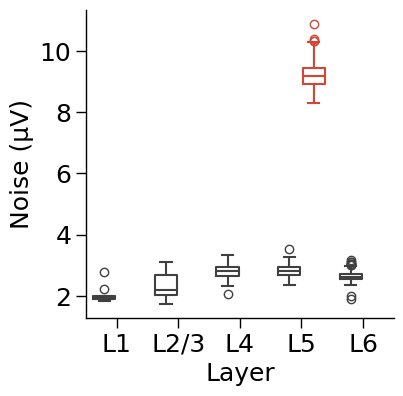

In [7]:
# FORMAT PLOT DATA ----------
# load precomputed noise data
vivo_noise_by_trace = np.load(NOISE_VIVO_DATAPATH, allow_pickle=True)
silico_noise_by_trace = np.load(NOISE_B_DATAPATH, allow_pickle=True)

layers = ["L1", "L2_3", "L4", "L5", "L6"]

# - get site layers
PreRecording_h_vivo = si.load_extractor(PREP_PATH_h_vivo)
vivo_layers = PreRecording_h_vivo.get_property("layers")

vivo_noise = []
sili_noise = []

# calculate noise stats by layer
for l_i in range(len(layers)):
    vivo_noise.append(np.array(vivo_noise_by_trace)[vivo_layers == layers[l_i]])
    sili_noise.append(np.array(silico_noise_by_trace))

# build dataset to plot
# - vivo data
vivo_data = pd.DataFrame(data=np.array(vivo_noise_by_trace), columns=["noise"])
vivo_data["layer"] = vivo_layers
vivo_data["experiment"] = "vivo"

# - silico data
sili_data = pd.DataFrame(data=np.array(silico_noise_by_trace), columns=["noise"])

# - group l2 and l3
sili_data["layer"] = "L5"
sili_data["experiment"] = "buccino"

plot_data = pd.concat([vivo_data, sili_data], ignore_index=True)

# drop sites outside layers
mask = np.isin(plot_data["layer"], layers)
plot_data = plot_data[mask]
plot_data = plot_data.sort_values(by=["layer"])


# PLOT ----------

fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE)

ax = sns.boxplot(
    ax=ax,
    data=plot_data,
    x="layer",
    y="noise",
    hue="experiment",
    fill=False,
    hue_order=["vivo", "buccino"],
    palette=[COLOR_VIVO, COLOR_SILI],
    gap=0.1,
    linewidth=1.5,
)
ax.spines[["top", "right"]].set_visible(False)
ax.legend("", frameon=False)
ax.set_ylabel("Noise (\u03bcV)")
ax.set_xlabel("Layer")
ax.set_box_aspect(BOX_ASPECT)  # square axis
ax.set_xticklabels(
    [
        "L1",
        "L2/3",
        "L4",
        "L5",
        "L6",
    ]
)

# save figures
plt.savefig(
    "figures/2_realism/2_noise/svg/layerwise_noise_stats_buccino.svg",
    bbox_inches="tight",
)